# period_outliers_py

---

## Determine growth and decline outliers for hpi change over time for certain multi-year periods

In [16]:
# Dependencies and Setup
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as st

# Import hpi-over-time data from cleaned file
file_path = "data/cleaned data/cleaned_hpi_price_data.csv"
hpi_df = pd.read_csv(file_path)

# Check that data seems to have loaded correctly
hpi_df.head()

,Five-Digit ZIP Code,Year,Annual Change (%),HPI,HPI from 2012,HPI with 2012 base,normalized_sale_price,zip_code,normalized_sale_price_2012
0,1001.0,1984,.,100.00,279.95,0.357207,58369.688570,1001.0,163405.943152
1,1001.0,1985,16.00,116.00,279.95,0.414360,67708.838742,1001.0,163405.943152
2,1001.0,1986,14.21,132.48,279.95,0.473227,77328.163418,1001.0,163405.943152
3,1001.0,1987,21.08,160.41,279.95,0.572995,93630.817436,1001.0,163405.943152
4,1001.0,1988,17.63,188.68,279.95,0.673977,110131.928394,1001.0,163405.943152


### Inspect the data for some general properties

In [17]:
# Find the most recent year that has data
recent_year = hpi_df['Year'].max()

# Find the oldest year that has data
oldest_year = hpi_df['Year'].min()

# Count how many unique years have data
year_count = hpi_df['Year'].unique().size

# Count how many unique zip codes and collect them into a list for iterating
zip_count = hpi_df['zip_code'].unique().size
zip_list = hpi_df['zip_code'].unique()

# Display some information that has been inspected
print(f"There is data for {year_count} years, from {oldest_year} to {recent_year}, covering {zip_count} unique zip codes")

print(hpi_df.dtypes)

# NOTE:  Different zip codes have different years available

There is data for 48 years, from 1975 to 2022, covering 13000 unique zip codes
Five-Digit ZIP Code           float64
Year                            int64
Annual Change (%)              object
HPI                           float64
HPI from 2012                 float64
HPI with 2012 base            float64
normalized_sale_price         float64
zip_code                      float64
normalized_sale_price_2012    float64
dtype: object


In [18]:
# Create a new dataframe that removes rows with no hpi value
period_growth_df = hpi_df.loc[hpi_df['HPI'] != -1]

# Sort the dataframe by year ascending so calculated results will tabulate in an intuitive way
period_growth_df = period_growth_df.sort_values(by=['Year'], ascending=True)

# Inspect the results
period_growth_df.head()

,Five-Digit ZIP Code,Year,Annual Change (%),HPI,HPI from 2012,HPI with 2012 base,normalized_sale_price,zip_code,normalized_sale_price_2012
447734,98125.0,1975,.,100.0,946.29,0.105676,31797.315704,98125.0,300894.818773
389734,91206.0,1975,.,100.0,998.51,0.100149,45416.795809,91206.0,453491.247834
330398,75081.0,1975,.,100.0,328.61,0.304312,47354.959662,75081.0,155613.132945
139421,30338.0,1975,.,100.0,417.05,0.239779,64438.388248,30338.0,268740.298188
417440,94536.0,1975,.,100.0,1063.98,0.093987,41858.690455,94536.0,445368.094701


---

## Determine growth and decline outliers for each period

In [19]:
# Create a dataframe that contains hpi values for the most recent year
recent_year_hpi_df = period_growth_df.loc[period_growth_df['Year']==recent_year][['Year', 'zip_code', 'HPI']]

# Inspect the results
recent_year_hpi_df

,Year,zip_code,HPI
10934,2022,2143.0,724.74
1004,2022,1069.0,329.90
456700,2022,99360.0,308.30
1190,2022,1081.0,212.53
61973,2022,14214.0,733.16
...,...,...,...
203435,2022,44057.0,533.58
203483,2022,44060.0,505.53
203520,2022,44062.0,301.68
203253,2022,44053.0,305.46


In [20]:
# Create list of multi-year periods to iterate through
periods_list = [3, 5, 10, 20, year_count-1]
check_years = []
for period in periods_list:
    check_year = recent_year - period
    check_years.append(check_year)

# Iterate through the periods and deterimine outliers for that period only
for year in check_years:
    
    # Create a dataframe that contains hpi values for the iteration year
    iteration_year_hpi_df = period_growth_df.loc[period_growth_df['Year']==year][['Year', 'zip_code', 'HPI']]

    # Join with the recent year data so that both years have data
    merge_df = pd.merge(iteration_year_hpi_df, recent_year_hpi_df, on='zip_code', how='left')

    # Inspect the results
    #merge_df
    
    # Make a list of zip codes that have data for both years
    zip_codes_list = merge_df['zip_code'].unique()
    
    # Compute change in hpi between recent year and check year for current period
    hpi_changes_list = []
    hpi_changes_zips = []
    for zip in zip_codes_list:
        hpi_changes_zips.append(zip)
        recent_hpi = merge_df.loc[merge_df['zip_code']==zip]['HPI_y'].values[0]
        check_hpi = merge_df.loc[merge_df['zip_code']==zip]['HPI_x'].values[0]
        change = recent_hpi - check_hpi
            
        hpi_changes_list.append(change)
        
    # Convert hpi_changes list into a dataframe for further analysis
    hpi_changes_df = pd.DataFrame()
    hpi_changes_df['hpi_change'] = hpi_changes_list
    hpi_changes_df['zip_code'] = hpi_changes_zips
        
    # Determine outliers using upper and lower bounds for that year and collect their zip codes
    quartiles = hpi_changes_df.quantile([0.25, 0.50, 0.75])
    lowerq = quartiles['hpi_change'].values[0]
    upperq = quartiles['hpi_change'].values[0]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
    # Collect the zip codes that are outliers
    outliers_df = hpi_changes_df.loc[(hpi_changes_df['hpi_change'] > upper_bound) 
                                     | (hpi_changes_df['hpi_change'] < lower_bound)]
    
    # Save the results to a file
    outliers_df.to_csv(f'data/analysis/outliers_{year}_to_{recent_year}.csv')

# Inspect one set of results
print(outliers_df)

     hpi_change  zip_code
0       2140.90   98125.0
1       1884.91   91206.0
2        715.10   75081.0
3        662.49   30338.0
4       2371.84   94536.0
..          ...       ...
655     1452.06   92860.0
656      335.12   44077.0
657     1793.14   94577.0
658     1656.56   90630.0
659     2290.81   93117.0

[654 rows x 2 columns]


**Visualization of Data**  

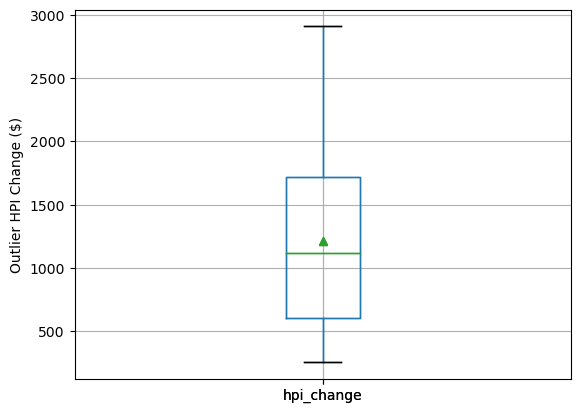

In [32]:
#boxplot of outlier HPI change data 
bplot = outliers_df.boxplot(column = 'hpi_change', showmeans=True)
bplot.set_ylabel("Outlier HPI Change ($)")
plt.savefig("Visuals/HPIboxplot.png")
plt.show()

# The following scatter plots will compare HPI values from current year (2022) and recession year (2009). The first few show 2022's data. 

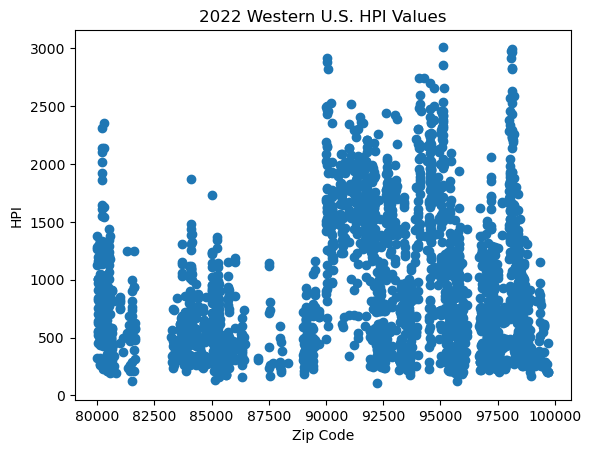

In [34]:
#Western US includes WA, OR, CA, ID, UT, NV, AZ, NM, CO, & WY
west_coast = recent_year_hpi_df[recent_year_hpi_df['zip_code']>= 80000]
plt.scatter(west_coast['zip_code'], west_coast['HPI'])
plt.title("2022 Western U.S. HPI Values")
plt.xlabel("Zip Code")
plt.ylabel("HPI")
plt.savefig("Visuals/2022westHPI.png")
plt.show()


This HPI graph nicely displays last year's HPI values for states with zipcoes starting with 8 and 9, AKA the west coast and western US. This includes WA, OR, CA, ID, UT, NV, AZ, NM, CO, & WY. We see the first peak in the Denver, CO area, there a large group of peaks representing California, and the last peak presumably representing Seattle, WA. 

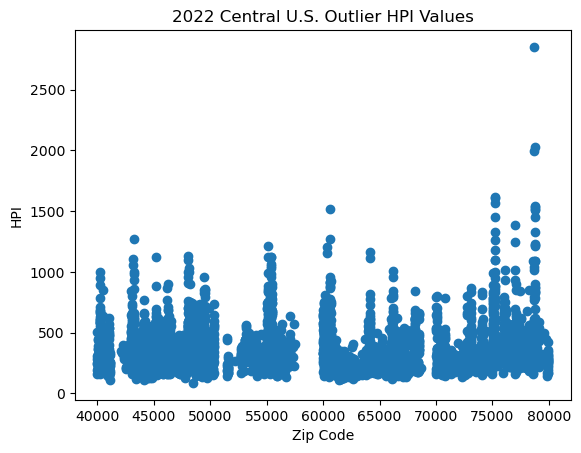

In [46]:
#Central US will include MT, ND, SD, NE, WI, MN, IA, KS, OK, TX, LA, AR, MO, IL, IN, MI, OH, and KY
central = recent_year_hpi_df[(recent_year_hpi_df['zip_code']>= 40000) & (recent_year_hpi_df['zip_code']< 80000)]
plt.scatter(central['zip_code'], central['HPI'])
plt.title("2022 Central U.S. Outlier HPI Values")
plt.xlabel("Zip Code")
plt.ylabel("HPI")
plt.savefig("Visuals/2022centralHPI.png")
plt.show()

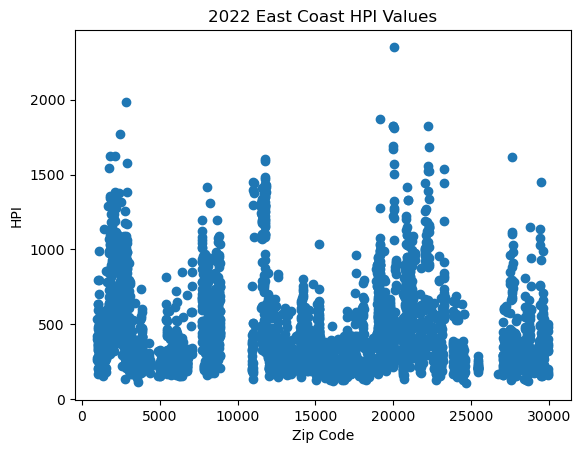

In [40]:
#east_coast includes ME, NH, VT, MA, CN, RI, NJ, NY, PN, MD, DC, WV, VI, NC, AND SC
east_coast = recent_year_hpi_df[recent_year_hpi_df['zip_code']<30000]
plt.scatter(east_coast['zip_code'], east_coast['HPI'])
plt.title("2022 East Coast HPI Values")
plt.xlabel("Zip Code")
plt.ylabel("HPI")
plt.savefig("Visuals/2022eastHPI.png")
plt.show()

In [41]:
#creating data from 2009 to show HPI effects from the 2008 recession 
rec_year_hpi_df = period_growth_df.loc[period_growth_df['Year']==2009][['Year', 'zip_code', 'HPI']]
rec_year_hpi_df.head()

,Year,zip_code,HPI
214877,2009,45148.0,100.86
291532,2009,61264.0,205.34
315063,2009,70087.0,207.31
308958,2009,67149.0,121.68
420056,2009,94612.0,121.71


# The following scatter plots display HPI value data from 2009 to represent the impacts of recession. 

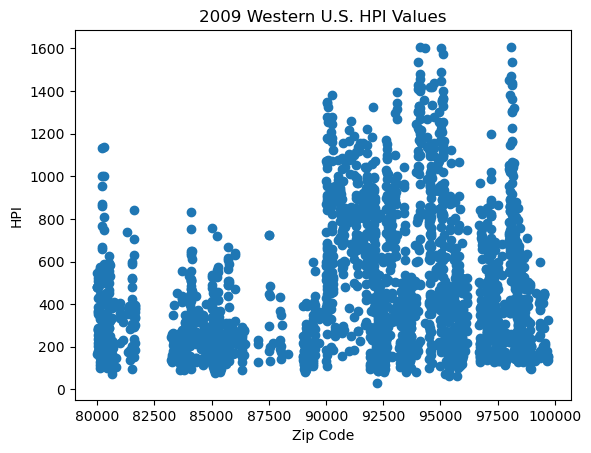

In [44]:
#2009 recession west coast HPI values. This includes WA, OR, CA, ID, UT, NV, AZ, NM, CO, & WY. 
west = rec_year_hpi_df[rec_year_hpi_df['zip_code']>=80000]
plt.scatter(west['zip_code'], west['HPI'])
plt.title("2009 Western U.S. HPI Values")
plt.xlabel("Zip Code")
plt.ylabel("HPI")
plt.savefig("Visuals/2009westHPI.png")
plt.show()

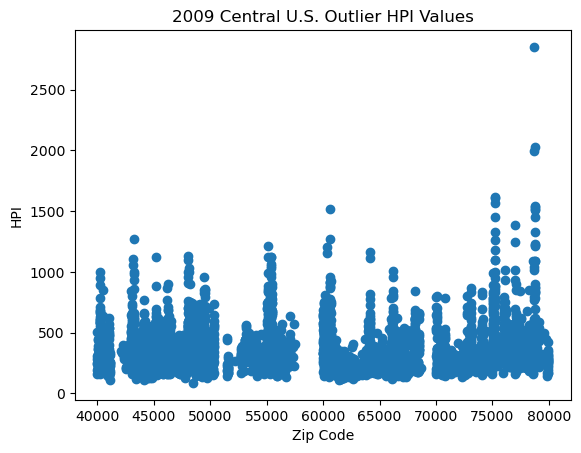

In [49]:
#Central US will include MT, ND, SD, NE, WI, MN, IA, KS, OK, TX, LA, AR, MO, IL, IN, MI, OH, and KY
cen_rec = recent_year_hpi_df[(recent_year_hpi_df['zip_code']>= 40000) & (recent_year_hpi_df['zip_code']< 80000)]
plt.scatter(cen_rec['zip_code'], cen_rec['HPI'])
plt.title("2009 Central U.S. Outlier HPI Values")
plt.xlabel("Zip Code")
plt.ylabel("HPI")
plt.savefig("Visuals/2009centralHPI.png")
plt.show()

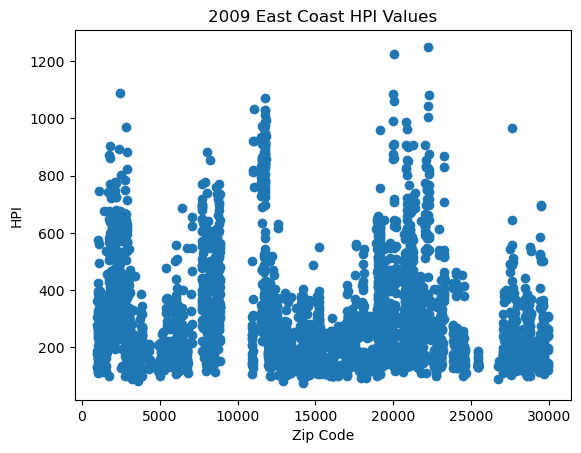

In [42]:
#East includes ME, NH, VT, MA, CN, RI, NJ, NY, PN, MD, DC, WV, VI, NC, AND SC. HPIs from 2009. 
east = rec_year_hpi_df[rec_year_hpi_df['zip_code']<30000]
plt.scatter(east['zip_code'], east['HPI'])
plt.title("2009 East Coast HPI Values")
plt.xlabel("Zip Code")
plt.ylabel("HPI")
plt.savefig("Visuals/2009eastHPI.png")
plt.show()
